파이썬 머신러닝 완벽가이드 개정2판 ch9.7~ 9 p.625 ~ 647

### **[개념 정리+코드 필사]📝**

### **07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

- 일반적 행렬분해는 SVD를 주로 사용
- 사용자-아이템 평점 행렬은 Null이 많으므로 SGD나 ALS 기반 이용 (실습에서는 SGD)

- 영화 평점 행렬 데이터는 pivot_table로 사용자-아이템 평점 행렬로 만들기

- 📃matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01): 행렬분해
  - R: 원본 사용자-아이템 평점 행렬
  - K: 잠재 요인의 차원수
  - steps: SGD반복 횟수
  - learning_rate: 학습률
  - r_lambda: L2 규제 계수
  - 예측 사용자-아이템 평점 행렬 반환--> 영화 타이틀을 칼럼으로 df변경해 사용

- 잠재 요인 협업 필터링: 예측 사용자-아이템 평점 행렬로 개인화된 영화 추출 시(앞선 get_unseen_movies(), recomm_movie_by_userid() 그대로 사용) 앞의 아이템 기반 협업 필터링과 다른 결과 확인가능



In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 null이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  X_non_zeros_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zeros_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[X_non_zeros_ind, y_non_zeros_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[X_non_zeros_ind, y_non_zeros_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [8]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
  num_users, num_items = R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력
  np.random.seed(1)
  P = np.random.normal(scale=1./K, size=(num_users, K))
  Q = np.random.normal(scale=1./K, size=(num_items, K))

  # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
  non_zeros = [ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트.
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제 값과 예측 값의 차이인 오류 값 구함
      eij = r - np.dot(P[i,:], Q[j,:].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i,:] = P[i,:] + learning_rate*(eij * Q[j,:] - r_lambda*P[i,:])
      Q[j,:] = Q[j,:] + learning_rate*(eij * P[i,:] - r_lambda*Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 10) == 0:
      print('### iteration step: ', step, 'rmse: ', rmse)

  return P, Q

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [9]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step:  0 rmse:  2.9023619751336867
### iteration step:  10 rmse:  0.7335768591017927
### iteration step:  20 rmse:  0.5115539026853442
### iteration step:  30 rmse:  0.37261628282537446
### iteration step:  40 rmse:  0.2960818299181014
### iteration step:  50 rmse:  0.2520353192341642
### iteration step:  60 rmse:  0.22487503275269854
### iteration step:  70 rmse:  0.2068545530233154
### iteration step:  80 rmse:  0.19413418783028685
### iteration step:  90 rmse:  0.18470082002720406
### iteration step:  100 rmse:  0.17742927527209104
### iteration step:  110 rmse:  0.1716522696470749
### iteration step:  120 rmse:  0.16695181946871726
### iteration step:  130 rmse:  0.16305292191997542
### iteration step:  140 rmse:  0.15976691929679646
### iteration step:  150 rmse:  0.1569598699945732
### iteration step:  160 rmse:  0.15453398186715425
### iteration step:  170 rmse:  0.15241618551077643
### iteration step:  180 rmse:  0.1505508073962831
### iteration step:  190 rmse:  

In [10]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index = ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,1.623927,3.910138,4.775403,3.837260,3.875488,1.550801,2.929129,2.680321,3.225626,3.251925,2.778350,3.331543,2.391855,3.199047,4.148949,1.852731,3.269642,3.448719,4.458060,3.719499,3.231820,3.521511,3.866924,3.961768,4.957933,4.075665,3.509040,3.923190,3.210152,4.374122,...,3.546313,3.207635,2.082641,3.302390,1.821505,3.814172,4.227119,3.699006,3.009256,4.605246,4.712096,4.284418,3.095067,3.214574,0.990303,1.805794,4.588016,2.295002,4.173353,0.327724,4.817989,1.902907,3.557027,2.881273,3.766529,2.703354,2.395317,2.373198,4.749076,4.281203,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,1.489588,3.617857,3.785199,3.168660,3.537318,0.995625,3.969397,2.173005,3.464055,2.475622,3.413724,2.665215,1.828840,3.322109,2.654698,1.469953,3.035060,3.163879,4.244324,2.727754,2.879571,3.124665,3.773794,3.774747,3.175855,3.458016,2.923885,3.303497,2.806202,3.504966,...,3.289954,2.677164,2.087793,3.388524,1.783418,3.267824,3.661620,3.131275,2.475330,3.916692,4.197842,3.987094,3.134310,2.827407,0.829738,1.380996,3.974255,2.685338,3.902178,0.293003,3.064224,1.566051,3.095034,2.769578,3.956414,2.493763,2.236924,1.775576,3.909241,3.799859,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,0.881095,1.813452,2.687841,1.908641,2.228256,0.695248,1.146590,1.536595,0.809632,1.561342,1.820714,1.097596,1.216409,1.347617,1.760926,0.622817,1.786144,1.934932,2.332054,2.291151,1.983643,1.785523,2.265654,2.055809,2.459728,2.092599,2.512530,2.928443,1.777471,1.808872,...,1.779506,2.222377,1.448616,2.340729,1.658322,2.231055,2.6

In [11]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
    # 반환된 user_rating은 영화명(title)을 인덱스를 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]

    #user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦.
    movies_list = ratings_matrix.columns.tolist()

    # list comporehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [17]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])

In [13]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


---

### **08. 파이썬 추천 시스템 패키지 - Surprise**

(1) Surprise 패키지 소개

- Surprise: 파이썬 기반 추천 시스템 구축을 위한 전용 패키지(사이킷런과 유사 API, 프레임워크 제공)
  - !pip install scikit-surprise
  - 다양한 추천 알고리즘(사용자/아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF기반 잠재요인 협업 필터링) 쉽게 적용 가능
  - fit(), predict(), train_test_slit(), cross_validate(), GridSearchCV 클래스 등 추천시스템을 위한 기능 제공



In [1]:
!pip install scikit-surprise

(2) Surprise를 이용한 추천 시스템 구축

데이터를 학습용/테스트용 세트로 분리 후 SVD행렬 분해 통한 잠재요인 협업 필터링
- Dataset로 데이터 로딩: userId, movieUd, rating같은 주요 데이터가 행 레벨 형태인 포맷만 처리
  - 자체적으로 행 레벨의 데이터를 칼럼 레벨의 데이터로 변경함
- load_builtin(): 무비렌즈 사이트 제공 과거 데이터를 로컬 디렉터리에 저장 후 로딩
  - 한번 사이트에서 내려받고 이후엔 로컬 디렉터리에서 로딩
- train_test_split으로 데이터 분리
  - train 데이터로 추천 알고리즘 학습: SVD()객체 생성 후 fit()
  - test 데이터에 대해 추천예측: test(), predict()
  - test():데이터 세트 전체에 대해 추천예측. 반환되는 리스트 객체는 개별 prediction객체를 내부에 가짐
    - prediction 객체: uid, iid, r_ui, est 속성
    - details 속성: 추천 예측을 할 수 없는 경우 로그용으로 데이터 남기는데 사용
  - predict(): 개별 사용자와 영화에 대한 추천 평점 반환. 개별 사용자 아이디와 아이템 아이디 문자열로 입력.
    - 추천예측 평점을 est로 반환
  - test()는 모든 사용자와 아이템 아이디에 대해 predict()를 반복적으로 수행한 결과

- accuracy()의 rmse(), mse()로 성능 평가

  





In [3]:
!pip install numpy==1.24.4

In [6]:
import surprise

print(surprise.__version__)

1.1.4


In [11]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [12]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [13]:
algo = SVD(random_state=0)
algo.fit(trainset)

In [14]:
predictions = algo.test(testset)
print('prediction type: ', type(predictions), 'size: ', len(predictions))
print('predicton 결과의 최초 5개 추출')
predictions[:5]

prediction type:  <class 'list'> size:  25000
predicton 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [15]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [16]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야함.
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [18]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

(3) Surprise 주요 모듈 소개

- 데이터의 칼럼을 **1.사용자 아이디, 2.아이템 아이디, 3.평점**으로 가정하고 이외는 로딩 수행X(순서 중요)
- API: Dataset.load_builtin(name='m1-100k'): 무비렌즈 아카이브 데이터, Dataset.load_from_file(file_path, reader):OS 파일에서 로딩, Dataset.load_from_df(df, reader): 판다스의 DataFrame에서 데이터 로딩

- ✅ OS 파일 데이터 -> Surprise 데이터
  - 칼럼명 헤더 삭제필요: header=False로 새 파일 저장 후 다시 로드
  - Reader() 클래스 생성: 파일의 파싱정보 저장. 각 필드의 칼럼명(line_format), 칼럼 분리문자(sep), 최소~최대 평점(rating_scale)
    - line_format='user item ... ': 칼럼명 명시
  - Dataset.load_from_file('df경로',reader=reader)
  - SVD(n_factors=50): 잠재요인 크기 K값=50으로 설정
  - 학습데이터로 학습, 테스트 데이터로 예측평점 구한 후 RMSE 평가

- ✅ 판다스 DataFrame -> Surprise 데이터
  - Dataset.load_from_df(data[['userId','movieId','rating']], reader=reader)
  - 칼럼 순서 잘 지키기. df[['userId','movieId','rating']]


In [19]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/ratings.csv')
# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA/OB 과제/ratings_noh.csv', index=False, header=False)

In [20]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA/OB 과제/ratings_noh.csv', reader=reader)

In [21]:
trainset, testset  = train_test_split(data, test_size=25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7940


0.7939608260279409

In [22]:
# 판다스 DataFrame에서 Surprise 데이터 세트로 로딩

import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야함.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

(4) Surprise 추천 알고리즘 클래스

- SVD: 행렬 분해를 통한 잠재 요인 협업 필터링을 위한 SVD 알고리즘
  - 파라미터: n_factors(잠재요인 K개수), n_epochs(SGD 수행시 반복 횟수), biased(베이스라인 사용자 편향 적용 여부)
- KNNBasic: 최근접 이웃 협업 필터링을 위한 KNN 알고리즘
- BaselineOnly: 사용자 Bias와 아이템 Bias를 감안한 SGD 베이스라인 알고리즘

- 추천 알고리즘 예측 성능 벤치마스 결과
  - SVD++가 가장 성적이 좋지만 시간이 너무 오래걸림. SVD와 k-NN Baseline이 다음으로 좋음.
  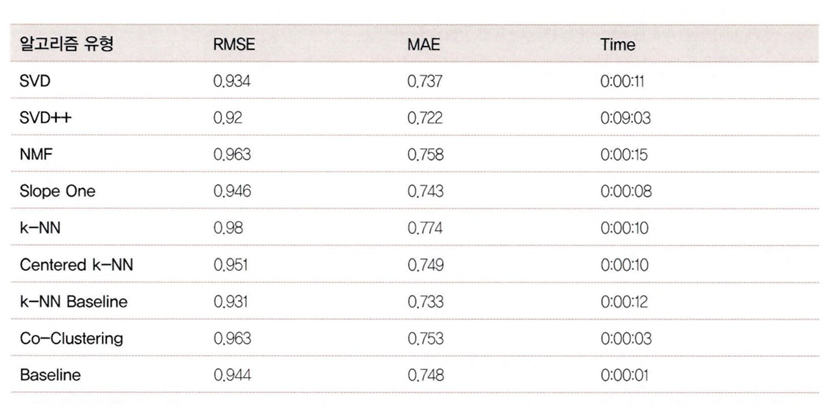


(5) 베이스라인 평점

- Baseline: 각 개인이 평점을 부여하는 성향 --> 평점에 편향성 요소 반영: Baseline 평점
- 전체 평균 평점+ 사용자 편향 점수+ 아이템 편향 점수
  - 전체 평균 평점 = 모든 사용자의 아이템 평점 평균
  - 사용자 편향 점수=사용자별 아이템 평점 평균 - 전체 평균 평점
  - 아이템 편향 점수=아이템별 평점 평균 - 전체 평균 평점

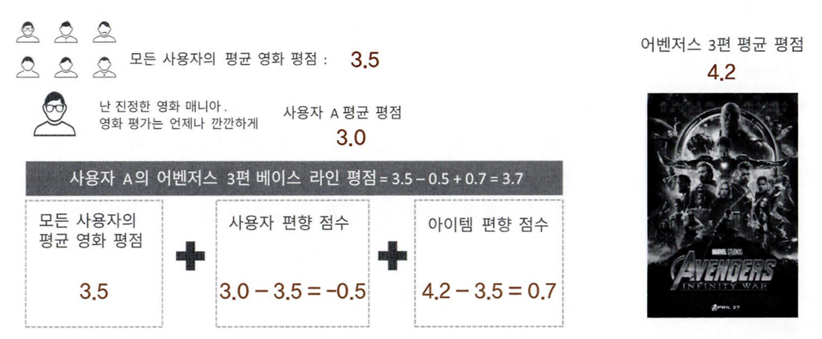

(6) 교차 검증과 하이퍼 파라미터 튜닝

- cross_validate(): 폴드된 데이터 세트의 개수와 성능 측정 방법을 명시해 교차 검증 수행
  - RMSE, MAE성능 평가
  - 입력인자: 알고리즘 객체, 데이터, 성능 평가 방법, 폴드 데이터 세트 개수(cv)
  - 출력: 폴드별 성능 평가 수치, 전체 폴드의 평균 성능 평가 수치
- GridSearchCV 클래스: 하이퍼 파라미터 최적화
  - SVD의 n_factors, n_epochs 튜닝

In [23]:
from surprise.model_selection import cross_validate

# Pandas DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8667  0.8752  0.8719  0.8793  0.8735  0.8733  0.0042  
MAE (testset)     0.6670  0.6733  0.6688  0.6754  0.6704  0.6710  0.0030  
Fit time          1.93    2.07    2.62    1.74    2.06    2.09    0.29    
Test time         0.11    0.19    0.39    0.15    0.25    0.22    0.10    


{'test_rmse': array([0.86665189, 0.87520251, 0.87189071, 0.87934911, 0.87349909]),
 'test_mae': array([0.66704421, 0.67326471, 0.66877146, 0.67543902, 0.67042248]),
 'fit_time': (1.9275791645050049,
  2.069617748260498,
  2.6222519874572754,
  1.7432665824890137,
  2.064535140991211),
 'test_time': (0.10880517959594727,
  0.18996047973632812,
  0.3909926414489746,
  0.14889001846313477,
  0.24878263473510742)}

In [24]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs': [20,40,60], 'n_factors': [50,100,200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8764989969885403
{'n_epochs': 20, 'n_factors': 50}


(7) Surprise를 이용한 개인화 영화 추천 시스템 구축

- 전체 데이터를 학습 데이터로 실습-> DatasetAutoFolds() 생성, build_full_trainset() 호출하면 됨
- SVD로 학습 수행 fit()
- predict(uid, iid, verbose=True): 아직 보지 않은 영화의 예측 평점 계산(est)
- get_unseen_surprise()함수 생성: 사용자가 아직 평점을 매기지 않은 영화 정보 반환
- recomm_movie_by_surprise()생성: prediction객체들을 리스트로 저장한 후, 예측 평점이 높은 순으로 정렬해 top-N개 객체들의 정보 추출해 반환

- Surprise 패키지로 복잡한 알고리즘을 직접 구현하지 않고 간결한 API를 이용해 추천시스템 구축 가능

In [26]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생함
# data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
# algo = SVD(n_factors=50, random_state=0)
# algo.fit(data)

In [27]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive/ESAA/OB 과제/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [28]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [29]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/movies.csv')

# userId=9의 movieID 데이터를 추출해 movieI=42 데이터가 있는지 확인.
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [30]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [31]:
def get_unseen_surprise(ratings, movies, userId):
  #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

  # 모든 영화의 moiveId를 리스트로 생성
  total_movies = movies['movieId'].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수: ', len(seen_movies), '추천 대상 영화 수: ', len(unseen_movies),
        '전체 영화 수: ', len(total_movies))

  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수:  46 추천 대상 영화 수:  9696 전체 영화 수:  9742


In [32]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):

  # 알고리즘 객체의 predict()매서드를 평점이 없는 영화에 반복 수행 후 결과를 list 객체로 저장
  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
  # [Prediction(uid='9', iid='1', est=3.69), Predcition(uid='9',iid='2',est=2.98),,,,]

  # 이를 est 값으로 정렬하기 위해 아래의 sortkey_est 함수를 정의
  # sortkey_est 함수는 list 객체의 sort()함수의 키 값으로 사용되어 정렬 수행
  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids = [int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']

  top_movie_preds = [(id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수:  46 추천 대상 영화 수:  9696 전체 영화 수:  9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


### **09. 정리**

- 콘텐츠 기반 필터링: 사용자가 좋아하는 아이템 요소들을 피처 벡터화한후 가장 유사한 피처 벡터를 가진 아이템 추천
- 협업 필터링
  - 최근접 이웃 협업 필터링: 코사인 유사도 이용
    - 사용자 기반(사용자-사용자)
    - 아이템 기반(아이템-아이템)
  - 잠재 요인 협업 필터링: 행렬분해로 잠재 요인을 추출. 경사하강법으로 구현

- Suprise 패키지: 간단한 API로 추천시스템 구현가능
